In [1]:
# Cord
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

# Scikit learn model selection
from sklearn.model_selection import (
    train_test_split,
    StratifiedKFold,
    RandomizedSearchCV,
    ParameterSampler,
    cross_validate,
)

# Scikit learn preprocessing
from sklearn.preprocessing import (
    StandardScaler,
    RobustScaler,
    OneHotEncoder,
    LabelEncoder,
)

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline 

# Models
from sklearn.linear_model import LogisticRegression, Perceptron
from sklearn.neural_network import MLPClassifier

# Metrics
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    confusion_matrix,
    ConfusionMatrixDisplay,
    make_scorer,
)

# Imbalanced learn
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE, SMOTENC, RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, regularizers, callbacks


A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.3.4 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "/opt/homebrew/lib/python3.11/site-packages/ipykernel_launcher.py", line 18, in <module>
    app.launch_new_instance()
  File "/opt/homebrew/lib/python3.11/site-packages/traitlets/config/application.py", line 1075, in launch_instance
    app.start()
  File "/opt/homebrew/lib/python3.11/site-packages/ipykernel/kernelapp.py", line 739, in start
    self.io_loop.start()
  File "/opt/homebrew/lib/python3.11/site-pack

If the code throws an error with regards to numpy, plese run the following cell. In my computer the requirements file for some reason was not installing the correct numpy version.

As of December 2025, TensorFlow is not yet fully compatible with NumPy 2.x, this forces NumPy to stay on version 1.x (safe for TF) and reinstalls it cleanly. Only needs to be run once per environment

In [2]:
!pip3 install "numpy<2" --force-reinstall --quiet


In [3]:
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, regularizers, callbacks
import numpy as np

In [4]:
import warnings
warnings.filterwarnings("ignore")

In this section of the book the aim is for us to get to the point where we use a neural network to predict churn. To make the journey smoother we start simple with something that feels close to a neural network with just one neuron, the perceptron. Then we move to logistic regression which, in terms of modeling, works just like the perceptron. The only crucial difference is the sigmoid function. This becomes our entry point to the chain rule when we update the weights which is the base we need to understand backpropagation, the powerhouse behind training a neural network.

Alongside this, the chapter also focuses on some feature engineering because we will be working with three different datasets:

- The form dataset which has the same information as the dataset we used in the tree based models chapter
- A dataset with call centre information
- A dataset with the data that shows the customer churned

In [5]:
# 1) Read the three CSV files
df_form = pd.read_csv('section_3_classification_form_dataset.csv')  
df_calls = pd.read_csv("section_3_classification_call_center_interactions.csv",  parse_dates=["date_call_start"])  # Multiple rows per customer
df_policy = pd.read_csv("section_3_classification_policy_data.csv", parse_dates=["policy_end_date"])  


# Code listing 8.1: Is everyone leaving us ? 

Is it time we face the truth. We need to create a churn flag to understand the behaviour of our customers.ç

In [6]:

# A user churned when policy_end_date has a real value.
# notna() checks for NaN.
# (policy_end_date != "") protects against empty strings.
df_policy["churn_flag"] = (
    df_policy["policy_end_date"].notna() &
    (df_policy["policy_end_date"] != "")
)

# Turn the boolean mask into 1 for churned and 0 for active
df_policy["churn_flag"] = df_policy["churn_flag"].astype(int)


# Table 8.1: Our distribution of customers by label.

Remember when we did a whole modeling project without checking the distribution of the labels we would observe in real life. Well now we will check this.

In [7]:
# Count frequencies
counts = df_policy["churn_flag"].value_counts()

# Convert to DataFrame
df_summary = counts.rename_axis("label").reset_index(name="freq")

# Add percentage column
df_summary["percent"] = (df_summary["freq"] / df_summary["freq"].sum()) * 100

df_summary


,label,freq,percent
0,0,2550,85.0
1,1,450,15.0


# Code listing 8.2: How long are you with us for?

Let's start by checking some behavioral metrics of the customers that churned.

In [8]:
# Select only churned customers
df_churned = df_policy[df_policy["churn_flag"] == 1].copy()

# Convert start and end dates to datetime format
df_churned["policy_start_date"] = pd.to_datetime(df_churned["policy_start_date"])
df_churned["policy_end_date"] = pd.to_datetime(df_churned["policy_end_date"])

# Compute the number of days between start and end dates
df_churned["days_to_churn"] = (
    df_churned["policy_end_date"] - df_churned["policy_start_date"]
).dt.days

# Get summary statistics
stats = df_churned["days_to_churn"].describe()


# Table 8.2: Our statistics fromt he customers that left us.

In [9]:
# Build a table with two columns, metric and value
df_stats_table = (
    stats.rename_axis("metric")
         .reset_index(name="value")
)

df_stats_table


,metric,value
0,count,450.000000
1,mean,338.802222
2,std,85.327659
3,min,162.000000
4,25%,273.000000
5,50%,331.500000
6,75%,401.750000
7,max,542.000000


# Figure 8.1: Why so many calls?

Another interesting thing to understand is how many calls each customer has. This will allow us to see the granularity we are working with when dealing with the call centre dataset. Later, if we wish to join it with the form, this information will be crucial.

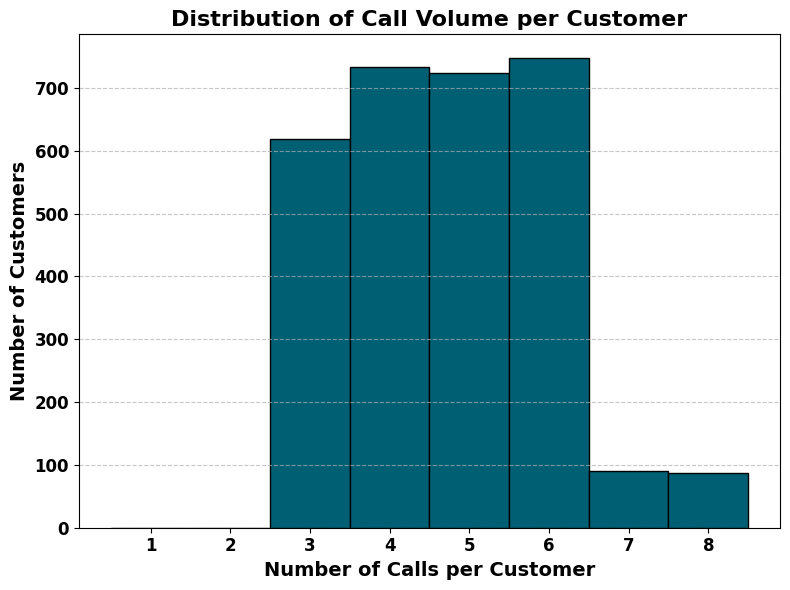

In [10]:
# Count how many distinct calls each customer made
call_counts = df_calls.groupby("customer_id")["call_id"].nunique()

# Create the histogram figure
plt.figure(figsize=(8, 6))

# Plot the distribution of call counts
# bins covers 1 up to the maximum number of calls
plt.hist(
    call_counts,
    bins=range(1, call_counts.max() + 2),  # one bin per integer count
    edgecolor='black',                      # outline for readability
    align='left',                           # center bars on integer values
    color='#005F73'                         # custom color
)

# Axis labels and title
plt.xlabel("Number of Calls per Customer", fontsize=14, fontweight='bold')
plt.ylabel("Number of Customers", fontsize=14, fontweight='bold')
plt.title("Distribution of Call Volume per Customer", fontsize=16, fontweight='bold')

# Tick formatting
plt.xticks(range(1, call_counts.max() + 1), fontsize=12, fontweight='bold')
plt.yticks(fontsize=12, fontweight='bold')

# Add a horizontal grid for readability
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Adjust spacing
plt.tight_layout()

# Display the plot and close the figure
plt.show()
plt.close()


# Code listing 8.3: A nice merge.

Well, let's merge those call logs with our dataset that has the policy end dates and therefore the labels. Once we do this we can start our real analysis.

In [11]:
df_calls_label = pd.merge(df_calls, df_policy, on="customer_id", how="inner")

# Code listing 8.5: The code that tells us the average calls.

Nothing like some averages to kick things off. Now that we have the labels and the call centre information joined we can work out some cool statistics around each customer. Because the call centre dataset is at a different level of granularity when compared with the dataset that has the dates when the policy ended, our dataset df_calls_label will have multiple entries per user, therefore we need to work with aggregations and statistics such as the mean and the std.

In [12]:
# Count how many distinct calls each customer made, separated by churn label
# This gives one row per customer with their churn status and number of calls
calls_per_user = (
    df_calls_label
    .groupby(["is_churn", "customer_id"])["call_id"]
    .nunique()
    .reset_index(name="call_count")
)

# Compute average and standard deviation of call volume for churned vs non churned customers
call_stats = (
    calls_per_user
    .groupby("is_churn")["call_count"]
    .agg(
        avg_calls_per_user='mean',   # average number of calls per customer
        std_calls_per_user='std'     # standard deviation of call counts
    )
    .reset_index()
)


# Table 8.9: How much are you calling us?

In [13]:
call_stats

,is_churn,avg_calls_per_user,std_calls_per_user
0,False,4.523529,1.119408
1,True,5.966667,1.417753


# Code listing 8.6: A good summary!

In [14]:
# Compute call duration
df_calls_label["date_call_start"] = pd.to_datetime(df_calls_label["date_call_start"])
df_calls_label["date_call_end"] = pd.to_datetime(df_calls_label["date_call_end"])
df_calls_label["call_duration"] = (df_calls_label["date_call_end"] - df_calls_label["date_call_start"]).dt.total_seconds() / 60

# Aggregate per customer
df_customer = df_calls_label.groupby("customer_id").agg(
    avg_call_length=("call_duration", "mean"),
    total_escalations=("escalated", "sum"),
    avg_satisfaction=("satisfaction_score", "mean"),
    churn_flag=("churn_flag", "first")
)

# Table 8.10: Just a few more averages.

In [15]:
# Averages per churn group
avg_table = df_customer.groupby("churn_flag").agg(
    avg_call_length=("avg_call_length", "mean"),
    avg_escalations=("total_escalations", "mean"),
    avg_satisfaction=("avg_satisfaction", "mean")
).reset_index()
avg_table

,churn_flag,avg_call_length,avg_escalations,avg_satisfaction
0,0,15.364714,1.001176,3.001542
1,1,17.178310,1.755556,3.010717


# Table 8.11: And their standard deviations.

In [16]:
# Standard deviations per churn group
std_table = df_customer.groupby("churn_flag").agg(
    std_call_length=("avg_call_length", "std"),
    std_escalations=("total_escalations", "std"),
    std_satisfaction=("avg_satisfaction", "std")
).reset_index()
std_table

,churn_flag,std_call_length,std_escalations,std_satisfaction
0,0,4.046431,0.913479,0.391611
1,1,3.513413,1.176147,0.344598


### The code we need to produce both tanles 8.12 and figure 8.6

We set a cutoff date and mark who churned based on whether they have a policy end date. Churners use their end date as the reference point, actives use the cutoff. We then compute how many days before that reference each call happened and keep only the calls that fall inside the last ninety days. After that, we label the rows as churn or non churn and count how many calls happen per day offset for each group. In the end, we pivot the results so churn and non churn sit side by side for easy comparison.

In [17]:
# Build churn flag and reference date
cutoff = pd.to_datetime("2024-04-01")

# Mark rows where there is a policy end date as churned
df_calls_label["is_churn"] = df_calls_label["policy_end_date"].notna()

# Reference date is the policy end date for churned customers
# and the cutoff date for active customers
df_calls_label["reference_date"] = np.where(
    df_calls_label["is_churn"],
    df_calls_label["policy_end_date"].fillna(cutoff),
    cutoff
)

# Ensure reference date never goes beyond the cutoff
df_calls_label["reference_date"] = pd.to_datetime(
    df_calls_label["reference_date"]
).clip(upper=cutoff)

# Days before reference date and window of ninety days
df_calls_label["date_call_start"] = pd.to_datetime(df_calls_label["date_call_start"])
df_calls_label["days_before"] = (
    df_calls_label["reference_date"] - df_calls_label["date_call_start"]
).dt.days

# Keep calls that fall within the last ninety days before reference
df_window = df_calls_label[df_calls_label["days_before"].between(0, 90)].copy()

# Label rows as churn or non churn
df_window["label"] = np.where(df_window["is_churn"], "Churn", "Non churn")

# Count calls per label and day offset
daily_calls = (
    df_window.groupby(["label", "days_before"])
             .size()
             .reset_index(name="calls")
)

# Pivot to have one column per label and one row per day offset
pivot = (
    daily_calls.pivot(index="days_before", columns="label", values="calls")
               .fillna(0)
               .reindex(columns=["Non churn", "Churn"], fill_value=0)
)

cust_counts = (
    df_window[["customer_id", "label"]]
    .drop_duplicates()
    .groupby("label")
    .size()
)
# Normalise calls so values represent calls per customer
pivot = pivot.div(cust_counts, axis=1)


# Table 8.12: Our distribution of customers by label

In [18]:
# Count distinct customers per label
cust_counts = (
    df_window[["customer_id", "label"]]
    .drop_duplicates()
    .groupby("label")
    .size()
)

# Convert to DataFrame
df_cust_counts = (
    cust_counts.rename_axis("label")
               .reset_index(name="freq")
)

# Add percent column
df_cust_counts["percent"] = (
    df_cust_counts["freq"] / df_cust_counts["freq"].sum() * 100
)


df_cust_counts

,label,freq,percent
0,Churn,370,12.671233
1,Non churn,2550,87.328767


# Figure 8.6: Average number of calls per customer across the days before their last recorded call 

After doing the pivot what we have left is to plot plot the cumulative curves for churn and non churn so we can see how their call activity builds up over time and how the patterns differ when approaching churn or the cutoff.

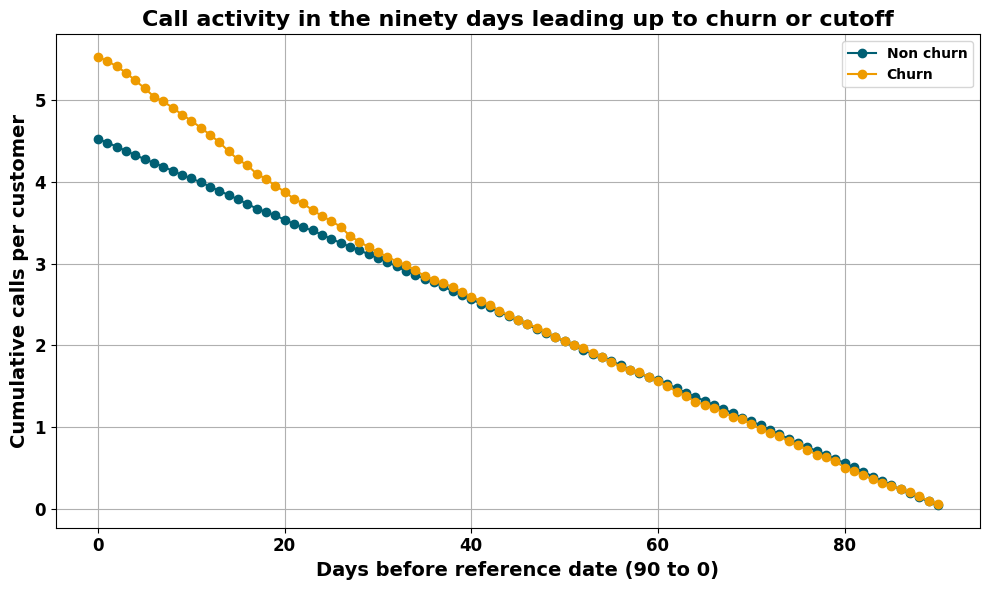

In [19]:
# Build cumulative calls curve, ordering days from ninety down to zero
curve = pivot.sort_index(ascending=False).cumsum()

# Set up the figure
plt.figure(figsize=(10, 6))

# Plot cumulative curve for non churn customers
plt.plot(curve.index, curve["Non churn"], marker="o", label="Non churn", color='#005F73')

# Plot cumulative curve for churn customers
plt.plot(curve.index, curve["Churn"], marker="o", label="Churn", color='#EE9B00')

# Axis labels and title
plt.xlabel("Days before reference date (90 to 0)", fontsize=14, fontweight='bold')
plt.ylabel("Cumulative calls per customer", fontsize=14, fontweight='bold')
plt.title("Call activity in the ninety days leading up to churn or cutoff", fontsize=16, fontweight='bold')

# Grid and tick formatting
plt.grid(True)
plt.xticks(fontsize=12, fontweight='bold')
plt.yticks(fontsize=12, fontweight='bold')

# Bold legend text
legend = plt.legend()
for text in legend.get_texts():
    text.set_fontweight('bold')

# Fit layout and save plot
plt.tight_layout()

# Show plot
plt.show()


# Figure 8.7: Share of total calls per seven day window in the ninety days before reference.

To obtain an additional piece of information, we decided to break the ninety-day window into seven-day chunks and assign each call to its matching window. Then we look at how many calls each group makes in each window and convert those counts into percentages of that group's total activity.

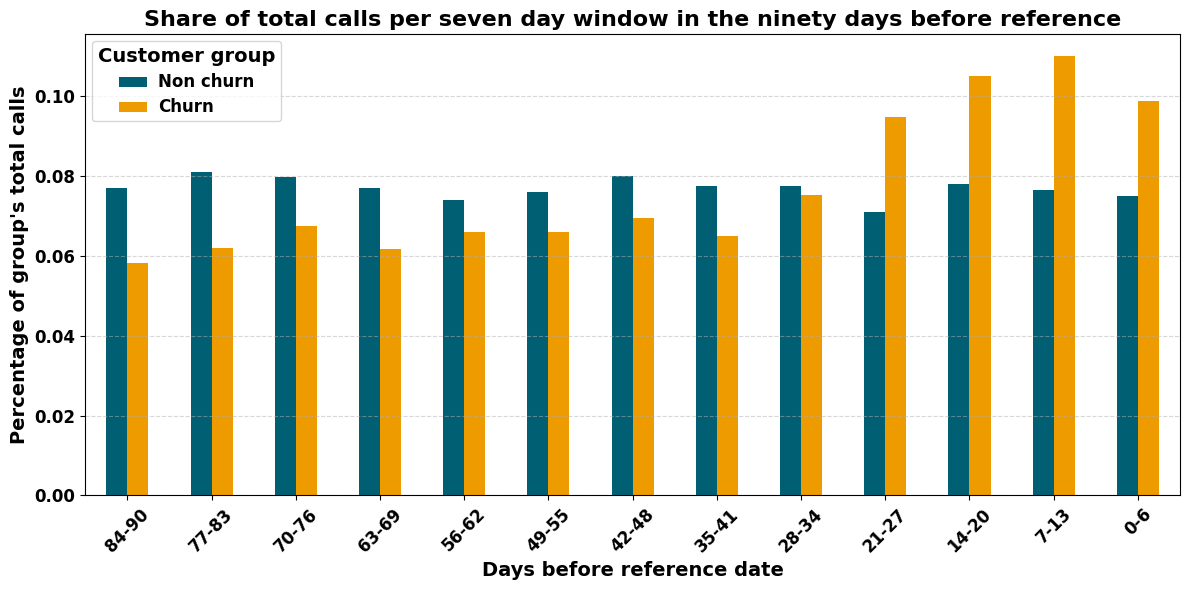

In [20]:
# Build seven day bins for the ninety day window
bins = list(range(0, 98, 7))            # boundaries for windows
labels = [f"{b}-{b+6}" for b in bins[:-1]]   # labels for each window

# Assign each call to a seven day window
df_window["time_window"] = pd.cut(
    df_window["days_before"],
    bins=bins,
    labels=labels,
    right=False
)

# Count calls per churn group and per window
group_counts = (
    df_window.groupby(["is_churn", "time_window"])
             .size()
             .reset_index(name="calls")
)

# Total calls per group for percentage conversion
totals = (
    df_window.groupby("is_churn")
             .size()
             .reset_index(name="total_calls")
)

# Merge totals and compute percent of calls in each window
group_counts = group_counts.merge(totals, on="is_churn")
group_counts["pct_calls"] = group_counts["calls"] / group_counts["total_calls"]

# Reshape so windows are rows and churn groups are columns
plot_df = (
    group_counts.pivot(index="time_window", columns="is_churn", values="pct_calls")
               .fillna(0)
               .rename(columns={False: "Non churn", True: "Churn"})
               .iloc[::-1]                          # reverse for top to bottom view
)

# Plot
colors = ["#005F73", "#EE9B00"]
plot_df.plot(kind="bar", figsize=(12, 6), color=colors)

plt.title("Share of total calls per seven day window in the ninety days before reference", fontsize=16, fontweight='bold')
plt.xlabel("Days before reference date", fontsize=14, fontweight='bold')
plt.ylabel("Percentage of group's total calls", fontsize=14, fontweight='bold')

plt.xticks(rotation=45, fontsize=12, fontweight='bold')
plt.yticks(fontsize=12, fontweight='bold')

# Legend formatting
legend = plt.legend(title="Customer group")
legend.get_title().set_fontweight('bold')
legend.get_title().set_fontsize(14)
for text in legend.get_texts():
    text.set_fontweight('bold')
    text.set_fontsize(12)

plt.grid(axis="y", linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()


# Code listing 8.7: Our feature set.

Our next step after the visual analysis is to roll the call log information up to the customer level so we can later join it with the data we already have from the form.

In [21]:
# Build per call helper features
# Compute call duration in minutes
df_window["call_duration"] = (
    df_window["date_call_end"] - df_window["date_call_start"]
).dt.total_seconds() / 60

# Measure how many days before the reference date the call happened
df_window["days_before_ref"] = (
    df_window["reference_date"] - df_window["date_call_start"]
).dt.days

# Create flags indicating whether the call falls inside each recent time window
df_window["in_7_days"]  = df_window["days_before_ref"].between(0, 6)
df_window["in_14_days"] = df_window["days_before_ref"].between(0, 13)
df_window["in_30_days"] = df_window["days_before_ref"].between(0, 29)

# Aggregate features at customer level
features = (
    df_window.groupby("customer_id").agg(
        total_calls_user      = ("call_id", "count"),        # total number of calls
        avg_call_length       = ("call_duration", "mean"),   # average duration
        total_call_length     = ("call_duration", "sum"),    # sum of all durations
        total_escalations     = ("escalated", "sum"),        # escalated calls
        avg_satisfaction      = ("satisfaction_score", "mean"),  # satisfaction average
        calls_last_7_days     = ("in_7_days", "sum"),        # calls in the short window
        calls_last_14_days    = ("in_14_days", "sum"),       # calls in the medium window
        calls_last_30_days    = ("in_30_days", "sum"),       # calls in the longer window
        churn_flag            = ("is_churn", "first")        # churn status
    )
    .reset_index()
)

# Compute share of each customer's calls that fall inside the recent windows
features["pct_calls_last_7_days"]  = (
    features["calls_last_7_days"]  / features["total_calls_user"]
)
features["pct_calls_last_14_days"] = (
    features["calls_last_14_days"] / features["total_calls_user"]
)
features["pct_calls_last_30_days"] = (
    features["calls_last_30_days"] / features["total_calls_user"]
)

# Select the feature columns you want to keep for modelling
desired_cols = [
    "customer_id", "churn_flag",
    "total_calls_user", "avg_call_length", "total_call_length",
    "total_escalations", "avg_satisfaction",
    "calls_last_7_days", "calls_last_14_days", "calls_last_30_days",
    "pct_calls_last_7_days", "pct_calls_last_14_days", "pct_calls_last_30_days"
]

df_features = features[desired_cols]


# Code listing 8.8: Join them!

Finally! This is where we put all the features that we created together, and you know what that means... a model is coming, baby!

In [22]:
full_feature_set  = pd.merge(df_form, df_features, on="customer_id", how="inner")

drop_cols = [
    "customer_id",
    "policy_id",
    "sign_date",
    "churn_date"
]

clean_set = full_feature_set.drop(columns=drop_cols, errors="ignore")

# Figure 8.13: Is anyone out there.

After arguing for the need to scale our feature set, we now look at which scaling method makes the most sense. And, of course, we have to deal with those inconvenient fellows we call outliers. In some fields outliers can be interesting, but in mathematics they usually just make our lives harder. Let's do that classic box plot.

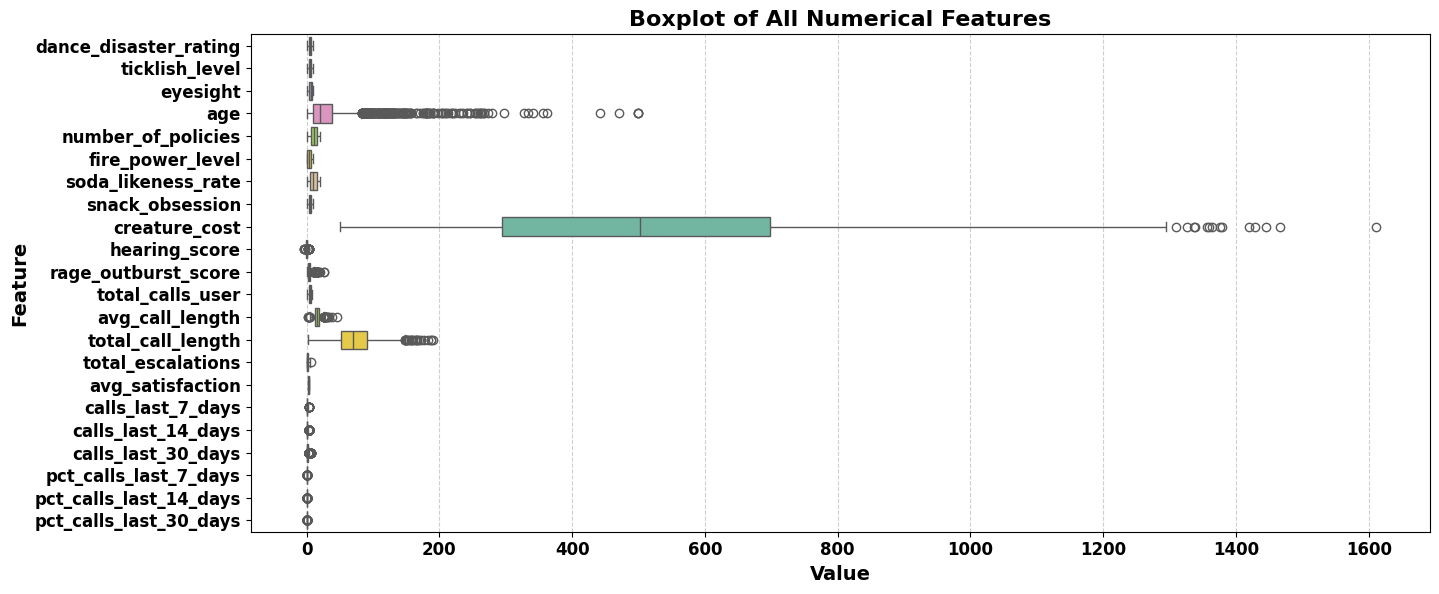

In [23]:
# Select only the numerical columns from the full feature set
numeric_df = clean_set.select_dtypes(include="number")

# Create the figure for the boxplot
plt.figure(figsize=(14, 6))

# Plot a horizontal boxplot for all numerical features
sns.boxplot(data=numeric_df, orient="h", palette="Set2")

# Titles and labels
plt.title("Boxplot of All Numerical Features", fontsize=16, fontweight='bold')
plt.xlabel("Value", fontsize=14, fontweight='bold')
plt.ylabel("Feature", fontsize=14, fontweight='bold')

# Add a grid on the x axis for readability
plt.grid(axis="x", linestyle="--", alpha=0.6)

# Adjust layout and style
plt.tight_layout()
plt.xticks(fontsize=12, fontweight='bold')
plt.yticks(fontsize=12, fontweight='bold')

plt.show()


# Code listing 8.10: Scale, scale, scale!

The time has come to train our perceptron and see what it can actually do when it comes to detecting churn. We will encode our categorical features using a one hot encoder and run two experiments: one where we scale the features with standard scaling and another where we use the robust scaler.

In [24]:
# Identify the categorical features in the dataset
categorical_cols = clean_set.select_dtypes(include=["object", "category"]).columns.tolist()

# One hot encode the categorical features and drop the first level to avoid redundancy
df_encoded = pd.get_dummies(clean_set, columns=categorical_cols, drop_first=True)

# Split the encoded dataset into features and target
X = df_encoded.drop("churn_flag", axis=1)
y = df_encoded["churn_flag"].values

# Create train and test sets with stratification to preserve class balance
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=42
)

# Extract only the numerical columns for scaling
numeric_cols = X.select_dtypes(include="number").columns.tolist()

# Apply standard scaling to the numerical features
std_scaler = StandardScaler()
X_train_std = X_train.copy()
X_test_std = X_test.copy()
X_train_std[numeric_cols] = std_scaler.fit_transform(X_train[numeric_cols])
X_test_std[numeric_cols] = std_scaler.transform(X_test[numeric_cols])

# Apply robust scaling to the numerical features for outlier resistant scaling
robust_scaler = RobustScaler()
X_train_robust = X_train.copy()
X_test_robust = X_test.copy()
X_train_robust[numeric_cols] = robust_scaler.fit_transform(X_train[numeric_cols])
X_test_robust[numeric_cols] = robust_scaler.transform(X_test[numeric_cols])


# Code listing 8.11: Give us all the performance metrics.

Because now we have several new metrics to analsys accross two difference scaling methods we decided to create a little function to help us eveluate our perceptron.

In [25]:
def evaluate_model(X_tr, X_te, y_tr, y_te, scaling_name="None"):
    """
    Evaluate a perceptron model under a given scaling setup.

    Arguments:
    X_tr         feature matrix for training
    X_te         feature matrix for testing
    y_tr         target labels for training
    y_te         target labels for testing
    scaling_name label used to identify which scaling method was applied
                 this is only for reporting purposes
    """

    # Create a perceptron classifier with a fixed random seed
    # max_iter controls how long it trains and tol is the early stopping threshold
    clf = Perceptron(max_iter=1000, tol=1e-3, random_state=42)

    # Fit the model on the training data
    clf.fit(X_tr, y_tr)

    # Predict class labels on the test data
    y_pred = clf.predict(X_te)

    # Compute the core evaluation metrics using macro averaging,
    # which gives equal weight to each class regardless of class imbalance
    accuracy  = accuracy_score(y_te, y_pred)
    precision = precision_score(y_te, y_pred, average='macro')
    recall    = recall_score(y_te, y_pred, average='macro')
    f1        = f1_score(y_te, y_pred, average='macro')

    # Build and plot the confusion matrix to visualise predictions per class
    cm = confusion_matrix(y_te, y_pred)
 
    # Package metrics into a DataFrame so results from multiple runs can be combined
    metrics_df = pd.DataFrame({
        "Scaling": [scaling_name],
        "Accuracy": [accuracy],
        "Precision (macro)": [precision],
        "Recall (macro)": [recall],
        "F1-score (macro)": [f1]
    })

    # Return the metrics table
    return metrics_df, cm


### Results for both our perceptron runs

In [26]:
standard_scaling_perceptron, cm_std = evaluate_model(X_train_std, X_test_std, y_train, y_test, scaling_name="standard scaler")
robust_scaling_perceptron, cm_rb = evaluate_model(X_train_robust, X_test_robust, y_train, y_test, scaling_name="robust scaler")


# Table 8.20: Perceptron performance metrics.

In [27]:
# Combine both results into a single DataFrame
perceptron_results = pd.concat(
    [standard_scaling_perceptron, robust_scaling_perceptron],
    ignore_index=True
)

perceptron_results


,Scaling,Accuracy,Precision (macro),Recall (macro),F1-score (macro)
0,standard scaler,0.829909,0.667260,0.744727,0.691292
1,robust scaler,0.777397,0.633673,0.737767,0.649625


# Table 8.21: Confusion matrix for Standard Scaler.

What about some colorfull confusion matrices? Cool!

Text(0.5, 1.0, 'Confusion Matrix - Standard scaler')

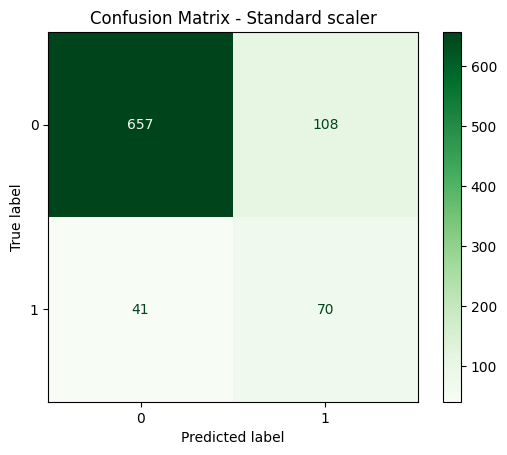

In [28]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm_std)
disp.plot(cmap="Greens", values_format="d")
plt.title(f"Confusion Matrix - Standard scaler")


# Table 8.22: Confusion matrix for Robust Scaler.

Text(0.5, 1.0, 'Confusion Matrix - Robust scaler')

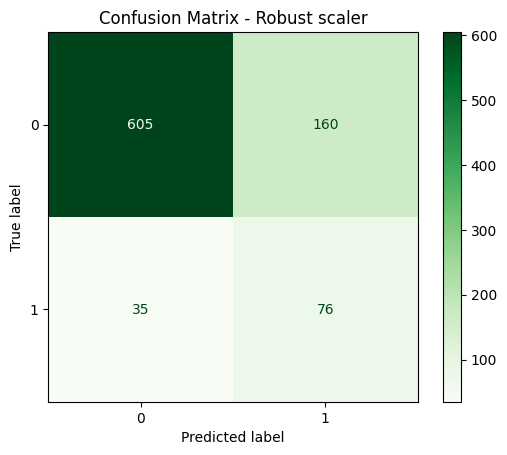

In [29]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm_rb)
disp.plot(cmap="Greens", values_format="d")
plt.title(f"Confusion Matrix - Robust scaler")


# Code listing 8.12: Fold as much as you want, but unfold some good results.

I think it comes as no surprise that we were going to bring some cross-folding back in the house. Bellow we will do some cross folding with our perceptron.

In [30]:
# Set up stratified k fold cross validation
# This keeps the class proportions similar in every split
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Define the scoring metrics we want to track in cross validation
# The keys are names we choose, the values are strings understood by sklearn
scoring = {
    "accuracy": "accuracy",
    "precision_macro": "precision_macro",
    "recall_macro": "recall_macro",
    "f1_macro": "f1_macro",
}

# Identify numeric and categorical columns from the full feature matrix X
# Numeric columns will be scaled, categorical columns will be one hot encoded
numeric_cols = X.select_dtypes(include="number").columns.tolist()
categorical_cols = X.select_dtypes(exclude="number").columns.tolist()

# Build a dictionary of pipelines, one for each scaling strategy
# Each pipeline has a preprocessing step and a perceptron classifier
pipelines = {
    name: Pipeline([
        # ColumnTransformer applies different preprocessing to numeric and categorical features
        ("preprocessor", ColumnTransformer(
            transformers=[
                # One hot encode categorical features and ignore unseen categories at test time
                ("cat", OneHotEncoder(handle_unknown="ignore", sparse_output=False), categorical_cols),
                # Apply the given scaler to numeric features
                ("num", scaler, numeric_cols)
            ],
            # Drop any columns not explicitly listed in the transformers
            remainder="drop"
        )),
        # Perceptron classifier with fixed random seed for reproducibility
        ("clf", Perceptron(max_iter=1000, tol=1e-3, random_state=42))
    ])
    # Here we build two pipelines, one with standard scaling and one with robust scaling
    for name, scaler in [
        ("Standard Scaler", StandardScaler()),
        ("Robust Scaler", RobustScaler())
    ]
}

# Dictionary to store cross validation results for each pipeline
results = {}

# Loop over each pipeline and run cross validation
for name, pipe in pipelines.items():
    # cross_validate returns a dictionary with metric values for each fold
    cv = cross_validate(
        estimator=pipe,
        X=X,
        y=y,
        cv=skf,
        scoring=scoring,
        n_jobs=-1,           # use all available cores
        error_score="raise"  # raise an error instead of silently failing
    )

    # Aggregate the test metrics across folds by taking the mean
    # cv keys look like "test_accuracy", "test_precision_macro", etc
    # We clean the names and convert them to a nicer title case format
    agg = {
        k.replace("test_", "").replace("_", " ").title(): np.mean(v)
        for k, v in cv.items()
        if k.startswith("test_")
    }

    # Store the aggregated metrics for this pipeline under its name
    results[name] = agg

# Convert the nested dictionary to a DataFrame
# Rows are scaling strategies, columns are metrics
results_df = pd.DataFrame(results).T.round(3)


# Table 8.24: We folded and folded again but have little to show for it.

In [31]:
results_df

,Accuracy,Precision Macro,Recall Macro,F1 Macro
Standard Scaler,0.824,0.661,0.592,0.587
Robust Scaler,0.829,0.588,0.570,0.567


# Code listing 8.13/8.14: A SMOTE onver and under trip

We are working with an imbalanced dataset, so it makes sense to try a few resampling techniques. The function below will let us run all these experiments with our dear perceptron. Fingers crossed it gives us something useful.

In [32]:
def evaluate_perceptron_all_strategies(X, y, random_state=42):
    """
    Run perceptron experiments across different resampling and scaling strategies.

    Arguments:
    X              feature matrix before preprocessing, containing both numeric and categorical columns
    y              target labels
    random_state   seed used for reproducibility across cross validation, samplers and classifier

    Returns:
    A DataFrame where each row represents a combination of:
      scaler used for numeric features
      resampling strategy applied before preprocessing
      averaged cross validation metrics for that setup
    """

    # Separate numeric and categorical columns from the raw feature matrix
    numeric_cols = X.select_dtypes(include="number").columns.tolist()
    categorical_cols = X.select_dtypes(exclude="number").columns.tolist()

    # Identify the integer column positions of the categorical features
    # Required by SMOTENC because it operates on the raw feature space
    cat_idx = [X.columns.get_loc(c) for c in categorical_cols]

    # Build stratified cross validation so each fold preserves the class balance
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_state)

    # Define the resampling techniques to test
    # None means no resampling
    strategies = {
        "No Resampling": None,
        "Undersample": RandomUnderSampler(random_state=random_state),
        "Oversample": RandomOverSampler(random_state=random_state),
        "SMOTENC": SMOTENC(
            categorical_features=cat_idx,
            random_state=random_state
        ),
    }

    # Define the scaling options for numeric data
    scalers = {
        "Standard": StandardScaler(),
        "Robust": RobustScaler()
    }

    # Store all experiment results here
    results = []

    # Metrics to compute during cross validation
    scoring = {
        "Accuracy": "accuracy",
        "Macro Precision": "precision_macro",
        "Macro Recall": "recall_macro",
        "Macro F1-score": "f1_macro",
    }

    # Loop over each scaling option
    for scaler_name, scaler in scalers.items():
        # Build a column transformer that applies one hot encoding to categoricals
        # and the chosen scaler to numeric columns
        preprocessor = ColumnTransformer(
            transformers=[
                ("cat", OneHotEncoder(handle_unknown="ignore", sparse_output=False), categorical_cols),
                ("num", scaler, numeric_cols),
            ]
        )

        # Loop over each resampling strategy
        for strategy_name, sampler in strategies.items():
            steps = []

            # If a resampling method is selected, add it before preprocessing
            # This is crucial because SMOTENC must operate on the raw input space
            if sampler is not None:
                steps.append(("sampler", sampler))

            # Add preprocessing and the perceptron classifier
            steps.append(("preprocessor", preprocessor))
            steps.append(("clf", Perceptron(max_iter=1000, tol=1e-3, random_state=random_state)))

            # Build an imbalanced learn pipeline so samplers and sklearn transforms
            # work together in the correct order
            pipe = ImbPipeline(steps)

            # Run cross validation for this configuration
            cv_results = cross_validate(
                pipe, X, y, cv=cv, scoring=scoring, n_jobs=-1
            )

            # Compute mean metric scores across all folds
            mean_scores = {
                metric: cv_results[f"test_{metric}"].mean()
                for metric in scoring.keys()
            }

            # Save the record for this pipeline setup
            results.append({
                 "Resampling": strategy_name,
                "Scaler": scaler_name,
                **mean_scores,
            })

    # Convert results into a DataFrame and sort by F1 score
    df = pd.DataFrame(results)
    return df.round(3).sort_values("Macro F1-score", ascending=False).reset_index(drop=True)


# Table 8.29: Combined results across scaling and resampling.

In [33]:
results = evaluate_perceptron_all_strategies(X, y)
results

,Resampling,Scaler,Accuracy,Macro Precision,Macro Recall,Macro F1-score
0,No Resampling,Standard,0.824,0.661,0.592,0.587
1,SMOTENC,Standard,0.718,0.576,0.633,0.567
2,No Resampling,Robust,0.829,0.588,0.570,0.567
3,SMOTENC,Robust,0.773,0.626,0.601,0.561
4,Undersample,Standard,0.593,0.570,0.639,0.504
5,Undersample,Robust,0.550,0.569,0.648,0.483
6,Oversample,Standard,0.563,0.580,0.649,0.481
7,Oversample,Robust,0.516,0.565,0.629,0.455


# Code listing 8.15/8.16/8.17.

Well since our function to evaluate the perceptron worked like a charm, we will do the same here with our logistic regression model

In [34]:
def evaluate_logistic_all_strategies(X, y, random_state=42, test_size=0.2, n_iter=15):
    numeric_cols = X.select_dtypes(include="number").columns.tolist()
    categorical_cols = X.select_dtypes(exclude="number").columns.tolist()

    cat_idx = [X.columns.get_loc(c) for c in categorical_cols]

    X_train, X_test, y_train, y_test = train_test_split(
        X,
        y,
        stratify=y,
        test_size=test_size,
        random_state=random_state,
    )

    outer_cv = StratifiedKFold(
        n_splits=5,
        shuffle=True,
        random_state=random_state
    )

    param_distributions = {
        "classifier__C": np.logspace(-3, 2, 20),
        "classifier__penalty": ["l1", "l2"],
        "classifier__solver": ["liblinear", "saga"],
    }

    strategies = {
        "No Resampling": None,
        "Undersample": RandomUnderSampler(random_state=random_state),
        "Oversample": RandomOverSampler(random_state=random_state),
        "SMOTENC": SMOTENC(
            categorical_features=cat_idx,
            random_state=random_state
        ),
    }

    scalers = {
        "Standard": StandardScaler(),
        "Robust": RobustScaler(),
    }

    results = []

    for scaler_name, scaler in scalers.items():
        preprocessor = ColumnTransformer(
            transformers=[
                (
                    "cat",
                    OneHotEncoder(handle_unknown="ignore", sparse_output=False),
                    categorical_cols,
                ),
                ("num", scaler, numeric_cols),
            ]
        )

        for strategy_name, sampler in strategies.items():
            steps = []

            if sampler is not None:
                steps.append(("sampler", sampler))

            steps.append(("preprocessor", preprocessor))
            steps.append(
                (
                    "classifier",
                    LogisticRegression(
                        max_iter=1000,
                        random_state=random_state,
                    ),
                )
            )

            pipe = ImbPipeline(steps)

            search = RandomizedSearchCV(
                estimator=pipe,
                param_distributions=param_distributions,
                n_iter=n_iter,
                cv=outer_cv,
                scoring=make_scorer(f1_score, average="macro"),
                n_jobs=-1,
                random_state=random_state,
                refit=True,
                verbose=0,
            )

            search.fit(X_train, y_train)

            best_model = search.best_estimator_

            # Only test predictions
            y_pred_test = best_model.predict(X_test)

            row = {
                "Scaler": scaler_name,
                "Resampling": strategy_name,
                "Test Accuracy": accuracy_score(y_test, y_pred_test),
                "Test Precision (Macro)": precision_score(
                    y_test, y_pred_test, average="macro"
                ),
                "Test Recall (Macro)": recall_score(
                    y_test, y_pred_test, average="macro"
                ),
                "Test F1 (Macro)": f1_score(
                    y_test, y_pred_test, average="macro"
                ),
                "Best Params": search.best_params_,
            }

            results.append(row)

    results_df = pd.DataFrame(results)

    results_df = (
        results_df.sort_values(by="Test F1 (Macro)", ascending=False)
        .reset_index(drop=True)
    )

    metric_cols = [
        "Test Accuracy",
        "Test Precision (Macro)",
        "Test Recall (Macro)",
        "Test F1 (Macro)",
        "Best Params",
    ]
    results_df[metric_cols] = results_df[metric_cols].round(4)

    return results_df


In [35]:
results_df = evaluate_logistic_all_strategies(X, y, random_state=42, test_size=0.2, n_iter=15)

# Table 8.33: Updated results across scaling and resampling.

Let us see what the logistic regression has in store for us.

In [36]:
# Select only the columns we want in the final comparison table
compact = results_df[[
    "Scaler",
    "Resampling",
    "Test Accuracy",
    "Test Precision (Macro)",
    "Test Recall (Macro)",
    "Test F1 (Macro)"
]].copy()

# Rename the metric columns to the clean final names
compact = compact.rename(columns={
    "Test Accuracy": "Accuracy",
    "Test Precision (Macro)": "Macro Precision",
    "Test Recall (Macro)": "Macro Recall",
    "Test F1 (Macro)": "Macro F1"
})

# Round the metrics for cleaner presentation
metric_cols = ["Accuracy", "Macro Precision", "Macro Recall", "Macro F1"]
compact[metric_cols] = compact[metric_cols].round(3)

# Return or display the compact table
compact


,Scaler,Resampling,Accuracy,Macro Precision,Macro Recall,Macro F1
0,Standard,No Resampling,0.897,0.836,0.629,0.672
1,Robust,No Resampling,0.897,0.836,0.629,0.672
2,Robust,SMOTENC,0.798,0.604,0.642,0.616
3,Standard,SMOTENC,0.800,0.603,0.637,0.614
4,Standard,Undersample,0.728,0.603,0.700,0.603
5,Robust,Oversample,0.712,0.603,0.708,0.597
6,Robust,Undersample,0.716,0.597,0.693,0.594
7,Standard,Oversample,0.707,0.594,0.688,0.587


# Code listing 8.18: A bug is not that bad.

Well well well, something is weird. We have two models with the exact same metrics, so let's check if our code is solid and if some bug has snuck in.

In [37]:
# Take a small subset of the training data so we can compare scalers quickly
X_sample = X_train.iloc[:200].copy()

# Build a preprocessing transformer that:
#   one hot encodes categorical columns
#   standard scales numeric columns
preproc_std = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore", sparse_output=False), categorical_cols),
        ("num", StandardScaler(), numeric_cols),
    ]
)

# Fit the StandardScaler transformer on the sample and transform it
Z_std = preproc_std.fit_transform(X_sample)

# Build a second preprocessing transformer that:
#   one hot encodes categorical columns
#   robust scales numeric columns
preproc_rob = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore", sparse_output=False), categorical_cols),
        ("num", RobustScaler(), numeric_cols),
    ]
)

# Fit the RobustScaler transformer on the same sample and transform it
Z_rob = preproc_rob.fit_transform(X_sample)

# Compare the two transformed matrices
print("same shape:", Z_std.shape, Z_rob.shape)   # Both produce the same number of features
print("identical:", np.allclose(Z_std, Z_rob))   # Check whether outputs are numerically identical


same shape: (200, 32) (200, 32)
identical: False


# Table 8.34: Best logistic regressiong hyper parameters for the no resampling case.

In [38]:
# Extract all best parameter dicts for each scaler
std_params = results_df.loc[results_df["Scaler"] == "Standard", "Best Params"].iloc[0]
rob_params = results_df.loc[results_df["Scaler"] == "Robust", "Best Params"].iloc[0]

# Build a new dataframe with hyperparameters as rows
params_df = pd.DataFrame({
    "Hyperparameter": list(std_params.keys()),
    "Standard Scaler": list(std_params.values()),
    "Robust Scaler": [rob_params[k] for k in std_params.keys()]
})

params_df


,Hyperparameter,Standard Scaler,Robust Scaler
0,classifier__solver,liblinear,liblinear
1,classifier__penalty,l2,l2
2,classifier__C,29.763514,29.763514


### Results for the perceptron and for the best performing logistic regression setup

We now train both models using the same preprocessing block and the same train test split so we can compare them fairly. After fitting each model we compute the macro F1 on the training set and on the test set. 

In [39]:
# ---------------------------------------------------------------
# 1. Select the best logistic regression configuration
#    We pick the row with Robust scaling and No Resampling.
# ---------------------------------------------------------------
best_row = results_df[
    (results_df["Scaler"] == "Robust") &
    (results_df["Resampling"] == "No Resampling")
].iloc[0]

# Extract the hyperparameters found through RandomizedSearchCV
best_params = best_row["Best Params"]

# ---------------------------------------------------------------
# 2. Build the preprocessing block
#    RobustScale numeric columns, pass categorical columns through
# ---------------------------------------------------------------
preprocessor = ColumnTransformer(
    transformers=[
        ("num", RobustScaler(), numeric_cols),
        ("cat", "passthrough", categorical_cols),
    ]
)

# ---------------------------------------------------------------
# 3. Rebuild the logistic regression model using the best params
# ---------------------------------------------------------------
log_clf = LogisticRegression(
    solver=best_params["classifier__solver"],
    penalty=best_params["classifier__penalty"],
    C=best_params["classifier__C"],
    max_iter=1000,
    random_state=42
)

# Full pipeline for logistic regression
log_pipeline = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("classifier", log_clf),
])

# ---------------------------------------------------------------
# 4. Train test split used for both models for a fair comparison
# ---------------------------------------------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# ---------------------------------------------------------------
# 5. Fit logistic regression and compute macro F1 on train and test
# ---------------------------------------------------------------
log_pipeline.fit(X_train, y_train)

y_pred_train_log = log_pipeline.predict(X_train)
y_pred_test_log  = log_pipeline.predict(X_test)

log_f1_train = f1_score(y_train, y_pred_train_log, average="macro")
log_f1_test  = f1_score(y_test,  y_pred_test_log,  average="macro")

# ---------------------------------------------------------------
# 6. Build a perceptron using the same preprocessing block
# ---------------------------------------------------------------
perc_clf = Perceptron(
    max_iter=1000,
    tol=1e-3,
    random_state=42
)

perc_pipeline = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("classifier", perc_clf),
])

# Fit perceptron
perc_pipeline.fit(X_train, y_train)

y_pred_train_perc = perc_pipeline.predict(X_train)
y_pred_test_perc  = perc_pipeline.predict(X_test)

perc_f1_train = f1_score(y_train, y_pred_train_perc, average="macro")
perc_f1_test  = f1_score(y_test,  y_pred_test_perc,  average="macro")

# ---------------------------------------------------------------
# 7. Create a comparison dataframe including absolute delta
# ---------------------------------------------------------------
results_compare = pd.DataFrame({
    "Model": ["Logistic Regression", "Perceptron"],
    "Macro F1 Train": [log_f1_train, perc_f1_train],
    "Macro F1 Test": [log_f1_test, perc_f1_test],
    "Abs Delta": [abs(log_f1_train - log_f1_test),
                  abs(perc_f1_train - perc_f1_test)]
})

# Round for clean display
results_compare = results_compare.round(3)

results_compare


,Model,Macro F1 Train,Macro F1 Test,Abs Delta
0,Logistic Regression,0.660,0.672,0.012
1,Perceptron,0.608,0.670,0.062


# Table 8.35: Now we can see who is working and who is not.

Let us take a look at the coefficients and see if we can squeeze a bit more information out of the logistic regression model.

In [40]:
# Get the trained logistic regression model from inside the pipeline
model = log_pipeline.named_steps["classifier"]

# Extract the learned coefficients
# Logistic regression stores one weight per feature
weights = model.coef_.flatten()  # flatten in case sklearn returns a 2D array

# Extract the intercept term (the bias)
bias = model.intercept_[0] if hasattr(model, "intercept_") else None

# Build a DataFrame that pairs each feature with its learned weight
coef_df = pd.DataFrame({
    "feature": X.columns,
    "coefficient": weights
})

# Add the intercept as an extra row at the bottom for completeness
coef_df.loc[len(coef_df)] = ["Intercept", bias]

# Display the full coefficient table
coef_df


,feature,coefficient
0,dance_disaster_rating,0.100168
1,ticklish_level,-0.012344
2,eyesight,-0.042707
3,age,0.004871
4,number_of_policies,-0.204959
5,fire_power_level,-0.059128
6,soda_likeness_rate,0.141333
7,snack_obsession,0.082464
8,creature_cost,0.201170
9,hearing_score,0.066136


# Code listing 8.19: How much? Is it a lot?

To understand how much a single feature influences the model, we can convert the logistic regression coefficient back into the original units of the data. Since we used a RobustScaler, the model learned weights on an IQR scaled version of the feature, not on the raw values. By dividing the weight by the scaler’s IQR, we recover the true log odds step associated with increasing the feature by one unit in its natural scale. Once we have that log odds step, we can push it through the logistic function and measure how much the predicted probability actually changes. This gives us a direct and intuitive quantity. On average, how much does the model’s predicted risk shift when this feature increases by one unit.

In [41]:
# -------------------------------------------------------------
# 1. Compute predicted probabilities on the test set
#    We need these to translate a log odds step into a change
#    in actual predicted probability.
# -------------------------------------------------------------
y_test_proba = log_pipeline.predict_proba(X_test)[:, 1]

# -------------------------------------------------------------
# 2. Choose the numeric feature we want to analyse
#    We will compute how much the predicted probability changes
#    when this feature increases by one unit in original scale.
# -------------------------------------------------------------
feature_name = "total_calls_user"

# Position of the feature inside the numeric block
num_idx = numeric_cols.index(feature_name)

# Pull the trained classifier and the preprocessing block
clf = log_pipeline.named_steps["classifier"]
preproc = log_pipeline.named_steps["preprocessor"]

# Extract the fitted RobustScaler for numeric features
scaler = preproc.named_transformers_["num"]

# -------------------------------------------------------------
# 3. Extract the raw logistic regression weight for that feature
# -------------------------------------------------------------
weight_raw = clf.coef_.ravel()[num_idx]

# -------------------------------------------------------------
# 4. RobustScaler scales by the IQR, stored in .scale_
#    To understand the effect in original units, we rescale
#    the coefficient back to the natural feature scale.
# -------------------------------------------------------------
iqr = scaler.scale_[num_idx]

# Effective log odds change for a +1 increase in the original feature
weight_eff = weight_raw / iqr

# -------------------------------------------------------------
# 5. Convert a log odds step into a probability change
#    This function takes a vector of probabilities and applies
#    a log odds shift, returning the new probability values
#    and the deltas.
# -------------------------------------------------------------
def prob_delta_from_logit_step(probs, step):
    odds_old = probs / (1 - probs)
    odds_new = odds_old * np.exp(step)
    probs_new = odds_new / (1 + odds_new)
    return probs_new - probs, probs_new

# Apply the transformation
delta_probs, probs_new = prob_delta_from_logit_step(y_test_proba, weight_eff)

# -------------------------------------------------------------
# 6. Show the average probability increase caused by +1 unit
#    in the original feature scale.
# -------------------------------------------------------------
print("Mean delta p:", float(np.mean(delta_probs)))


Mean delta p: 0.10837275219083967


# The grand final step. Our neural network built with keras.

After all this work we finally get to build a neural network. Here we will use keras, a more flexible library and also what we will use to create our convolutional neural networks. Keras is more flexible than sci kit learn and allows us to build networks by layers which is perfect if we want to do cool stuff with these networks. For example, we can stack layers, add and remove regularization methods, create new architectures, and even mix neural networks. We can mix a feedforward network with a CNN, more on this in the CNN notebook.

For now we will do the same experiments we did with the perceptron and logistic regression but apply them to a neural network. This means doing some hyperparameter tuning and these bad boys will give us a few more hyper parameters to play with.

In [42]:
# -------------------------------------------------------------
# 1. Identify numeric and categorical columns
#    We need these to build the preprocessing pipeline.
# -------------------------------------------------------------
numeric_cols = X.select_dtypes(include="number").columns.tolist()
categorical_cols = X.select_dtypes(exclude="number").columns.tolist()

# For SMOTENC we must give column *positions*, not names
cat_idx = [X.columns.get_loc(c) for c in categorical_cols]


# -------------------------------------------------------------
# 2. Define scaling strategies and resampling strategies
#    The model will be evaluated under all scaler-resampler pairs.
# -------------------------------------------------------------
scalers = {
    "standard": StandardScaler(),
    "robust": RobustScaler()
}

resamplers = {
    "none": None,   # no resampling
    "smotenc": SMOTENC(categorical_features=cat_idx, random_state=42),
    "oversample": RandomOverSampler(random_state=42),
    "undersample": RandomUnderSampler(random_state=42)
}


# -------------------------------------------------------------
# 3. Define the neural network hyperparameter search space
#    ParameterSampler randomly selects combinations from this grid.
# -------------------------------------------------------------
param_grid = {
    "n_hidden_layers": [1, 2, 3],
    "n_units": [18, 32, 64, 128],
    "activation": ['relu'],
    "batch_size": [64, 64, 128],
    "epochs": [50,],
    "optimizer": ['adam', 'rmsprop', 'sgd'],
    "learning_rate": [1e-3,1e-4 , 1e-2]
}

# Select 4 random configurations from the hyperparameter grid
random_params = list(ParameterSampler(param_grid, n_iter=4, random_state=42))


# -------------------------------------------------------------
# 4. Define cross validation
#    StratifiedKFold maintains class balance across folds.
# -------------------------------------------------------------
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

results = []  # store results across all configurations


# -------------------------------------------------------------
# 5. Loop over every scaler
#    Each scaler is fit *inside* the CV loop to avoid leakage.
# -------------------------------------------------------------
for scaler_name, scaler in scalers.items():

    # Preprocessing: one hot encode categoricals and scale numeric features
    # This transformer will be fitted only on each train fold.
    preprocessor = ColumnTransformer(
        transformers=[
            ("cat", OneHotEncoder(handle_unknown="ignore", sparse_output=False), categorical_cols),
            ("num", scaler, numeric_cols)
        ],
        remainder="drop"
    )
    
    # ---------------------------------------------------------
    # 6. Loop over resampling strategies
    #    Resampling happens BEFORE preprocessing to avoid leakage.
    # ---------------------------------------------------------
    for resample_name, resampler in resamplers.items():
        
        # ---------------------------------------------------------
        # 7. Loop over the neural network hyperparameter samples
        # ---------------------------------------------------------
        for params in random_params:

            # Prepare metric storage for this configuration
            metrics = {m: [] for m in ['Accuracy', 'Precision', 'Recall', 'F1']}

            # ---------------------------------------------------------
            # 8. Cross validation loop
            # ---------------------------------------------------------
            for train_idx, test_idx in cv.split(X, y):

                # Clear the Keras backend to avoid graph accumulation
                tf.keras.backend.clear_session()

                # Extract raw data for this fold
                X_train_raw = X.iloc[train_idx]
                X_test_raw  = X.iloc[test_idx]
                y_train = y[train_idx]
                y_test  = y[test_idx]

                # -----------------------------------------------------
                # 9. Apply resampling on *raw* train data only
                #    SMOTENC and others must see raw categorical columns.
                # -----------------------------------------------------
                if resampler is not None:
                    try:
                        X_train_resampled, y_train = resampler.fit_resample(X_train_raw, y_train)
                        y_train = y_train.ravel()
                    except Exception:
                        # If resampling fails, skip this fold
                        continue

                    # Skip invalid folds produced by extreme imbalance
                    if X_train_resampled.shape[0] == 0 or y_train.shape[0] == 0:
                        continue
                    if np.unique(y_train).size < 2:
                        continue
                else:
                    X_train_resampled = X_train_raw

                # -----------------------------------------------------
                # 10. Preprocess (OHE + scaling)
                #     fit_transform on train, transform on test
                #     ensures no leakage from test into train.
                # -----------------------------------------------------
                X_train_processed = preprocessor.fit_transform(X_train_resampled).astype(np.float32)
                X_test_processed  = preprocessor.transform(X_test_raw).astype(np.float32)

                # -----------------------------------------------------
                # 11. Build the neural network with the sampled params
                # -----------------------------------------------------
                model = models.Sequential()
                model.add(layers.Input(shape=(X_train_processed.shape[1],)))

                for _ in range(params['n_hidden_layers']):
                    model.add(layers.Dense(
                        params['n_units'],
                        activation=params['activation'],
                        kernel_regularizer=regularizers.l2(1e-4)
                    ))
                
                # Output layer: probability of the positive class
                model.add(layers.Dense(1, activation='sigmoid'))

                # -----------------------------------------------------
                # 12. Compile with chosen optimizer and learning rate
                # -----------------------------------------------------
                opt_cls = {
                    'adam': optimizers.Adam,
                    'sgd': optimizers.SGD,
                    'rmsprop': optimizers.RMSprop
                }[params['optimizer']]

                opt = opt_cls(learning_rate=params['learning_rate'])

                model.compile(
                    optimizer=opt,
                    loss='binary_crossentropy',
                    metrics=['accuracy']
                )

                # -----------------------------------------------------
                # 13. Train with early stopping to stabilise performance
                # -----------------------------------------------------
                early_stop = callbacks.EarlyStopping(
                    monitor='loss',
                    patience=10,
                    restore_best_weights=True
                )

                model.fit(
                    X_train_processed, y_train,
                    epochs=params['epochs'],
                    batch_size=params['batch_size'],
                    verbose=0,
                    shuffle=True,
                    callbacks=[early_stop],
                )

                # -----------------------------------------------------
                # 14. Predict on test fold and compute metrics
                # -----------------------------------------------------
                y_score = model.predict(X_test_processed).flatten()
                y_pred  = (y_score > 0.5).astype(int)

                # Macro metrics treat each class equally
                metrics['Accuracy'].append(accuracy_score(y_test, y_pred))
                metrics['Precision'].append(precision_score(y_test, y_pred, average='macro', zero_division=0))
                metrics['Recall'].append(recall_score(y_test, y_pred, average='macro', zero_division=0))
                metrics['F1'].append(f1_score(y_test, y_pred, average='macro', zero_division=0))

            # If no valid folds were collected, skip this configuration
            if not any(metrics.values()):
                continue

            # Average the metrics across folds
            avg = {k: round(np.mean(v), 3) for k, v in metrics.items()}

            # Store results for this scaler + resampler + params combination
            results.append({
                "Scaler": scaler_name,
                "Resampler": resample_name,
                **params,
                **avg
            })


# -------------------------------------------------------------
# 15. Convert all results into a dataframe, sorted by F1 score
# -------------------------------------------------------------
results_df = pd.DataFrame(results)
results_df = results_df.sort_values(by="F1", ascending=False).reset_index(drop=True)

# Define which columns identify the model configuration clearly
param_cols = [
    "Scaler",
    "Resampler",
    "n_hidden_layers",
    "n_units",
    "activation",
    "batch_size",
    "epochs",
    "optimizer",
    "learning_rate"
]

# Extract the best configuration
best_params = results_df.loc[0, param_cols]

best_params

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Scaler             robust
Resampler            none
n_hidden_layers         1
n_units               128
activation           relu
batch_size             64
epochs                 50
optimizer            adam
learning_rate       0.001
Name: 0, dtype: object

### A massive table with everything!

In [43]:
results_df

,Scaler,Resampler,optimizer,n_units,n_hidden_layers,learning_rate,epochs,batch_size,activation,Accuracy,Precision,Recall,F1
0,robust,none,adam,128,1,0.001,50,64,relu,0.908,0.843,0.690,0.735
1,standard,none,adam,128,1,0.001,50,64,relu,0.909,0.848,0.688,0.735
2,robust,none,adam,18,3,0.001,50,64,relu,0.901,0.807,0.683,0.723
3,robust,none,adam,18,1,0.001,50,64,relu,0.909,0.882,0.668,0.719
4,standard,none,adam,18,1,0.001,50,64,relu,0.908,0.870,0.666,0.716
5,standard,none,adam,18,3,0.001,50,64,relu,0.893,0.771,0.675,0.708
6,robust,smotenc,adam,128,1,0.001,50,64,relu,0.872,0.709,0.669,0.684
7,standard,smotenc,adam,18,1,0.001,50,64,relu,0.863,0.688,0.676,0.681
8,standard,oversample,adam,128,1,0.001,50,64,relu,0.846,0.667,0.691,0.677
9,robust,smotenc,adam,18,1,0.001,50,64,relu,0.859,0.681,0.675,0.677


### Overfit verification on the optimised neural network.

Yes, we need to check if we are overfitting. Neural networks are complex and deep models, so this step is important. The test we will do is the classic one of training a neural network on our training set with the best set of parameters returned from the grid search and then doing our checks by calculating the performance metrics in the training set versus the hold out set.

In [44]:
# -----------------------------
# 1. Extract best configuration
# -----------------------------
best_params = results_df.loc[0, param_cols]

scaler_name     = best_params["Scaler"]
resampler_name  = best_params["Resampler"]
n_layers        = best_params["n_hidden_layers"]
n_units         = best_params["n_units"]
activation      = best_params["activation"]
batch_size      = best_params["batch_size"]
epochs          = best_params["epochs"]
optimizer_name  = best_params["optimizer"]
learning_rate   = best_params["learning_rate"]


# -----------------------------
# 2. Build scaler automatically
# -----------------------------
scaler_dict = {
    "standard": StandardScaler(),
    "robust": RobustScaler()
}
scaler = scaler_dict[scaler_name]


# -----------------------------
# 3. Train test split and scale
# -----------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

X_train_scaled = scaler.fit_transform(X_train).astype(np.float32)
X_test_scaled  = scaler.transform(X_test).astype(np.float32)


# -----------------------------
# 4. Build optimizer automatically
# -----------------------------
opt_dict = {
    "adam": optimizers.Adam,
    "sgd": optimizers.SGD,
    "rmsprop": optimizers.RMSprop
}

optimizer = opt_dict[optimizer_name](learning_rate=learning_rate)


# -----------------------------
# 5. Build neural network using best parameters
# -----------------------------
model = models.Sequential()
model.add(layers.Input(shape=(X_train_scaled.shape[1],)))

# Add the selected number of hidden layers, each with the selected units
for _ in range(n_layers):
    model.add(layers.Dense(
        n_units,
        activation=activation,
        kernel_regularizer=regularizers.l2(1e-4)
    ))

model.add(layers.Dense(1, activation="sigmoid"))

model.compile(
    optimizer=optimizer,
    loss="binary_crossentropy",
    metrics=["accuracy"]
)


# -----------------------------
# 6. Train the model
# -----------------------------
model.fit(
    X_train_scaled, y_train,
    epochs=epochs,
    batch_size=batch_size,
    verbose=0,
    shuffle=True
)


# -----------------------------
# 7. Predict on train and test
# -----------------------------
y_train_score = model.predict(X_train_scaled).flatten()
y_test_score  = model.predict(X_test_scaled).flatten()

y_train_pred = (y_train_score > 0.5).astype(int)
y_test_pred  = (y_test_score > 0.5).astype(int)


# -----------------------------
# 8. Build predictions dataframe
# -----------------------------
df_predictions = pd.DataFrame({
    "y_train_true": y_train,
    "y_train_pred": y_train_pred,
    "y_train_score": y_train_score,
})

df_predictions_test = pd.DataFrame({
    "y_test_true": y_test,
    "y_test_pred": y_test_pred,
    "y_test_score": y_test_score,
})

df_predictions_full = {
    "train": df_predictions,
    "test": df_predictions_test
}


# -----------------------------
# 9. Build metrics dataframe
# -----------------------------
metrics_dict = {
    "Set": ["Train", "Test"],
    "Accuracy": [
        accuracy_score(y_train, y_train_pred),
        accuracy_score(y_test, y_test_pred),
    ],
    "Precision": [
        precision_score(y_train, y_train_pred, average="macro", zero_division=0),
        precision_score(y_test, y_test_pred, average="macro", zero_division=0),
    ],
    "Recall": [
        recall_score(y_train, y_train_pred, average="macro", zero_division=0),
        recall_score(y_test, y_test_pred, average="macro", zero_division=0),
    ],
    "F1": [
        f1_score(y_train, y_train_pred, average="macro", zero_division=0),
        f1_score(y_test, y_test_pred, average="macro", zero_division=0),
    ]
}

df_metrics = pd.DataFrame(metrics_dict).round(3)


# -----------------------------
# 10. Show final tables
# -----------------------------
df_metrics


73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 352us/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


,Set,Accuracy,Precision,Recall,F1
0,Train,0.934,0.947,0.749,0.811
1,Test,0.909,0.838,0.700,0.744


# Neural Network with dropout and batch Normalization

New stuff new optimisaiton, you know how it goes. We introduced some new regularization tecnoiques, namely the batch normalization and the dropout and because of that it is good practice we do our hyper parameter tunning once again. The hyper parameter search space will be the same with the adition of the droput probabilites, are you ready to roll ? 

In [45]:
# -------------------------------------------------------------
# 1. Identify numeric and categorical columns
# -------------------------------------------------------------
numeric_cols = X.select_dtypes(include="number").columns.tolist()
categorical_cols = X.select_dtypes(exclude="number").columns.tolist()

# For SMOTENC we must give column positions
cat_idx = [X.columns.get_loc(c) for c in categorical_cols]


# -------------------------------------------------------------
# 2. Define scaling and resampling strategies
# -------------------------------------------------------------
scalers = {
    "standard": StandardScaler(),
    "robust": RobustScaler()
}

resamplers = {
    "none": None,
    "smotenc": SMOTENC(categorical_features=cat_idx, random_state=42),
    "oversample": RandomOverSampler(random_state=42),
    "undersample": RandomUnderSampler(random_state=42)
}


# -------------------------------------------------------------
# 3. Hyperparameter grid including dropout and batch norm
# -------------------------------------------------------------
param_grid = {
    "n_hidden_layers": [1, 2, 3],
    "n_units": [18, 32, 64, 128],
    "activation": ['relu'],
    "batch_size": [64, 128],
    "epochs": [50],
    "optimizer": ['adam', 'rmsprop', 'sgd'],
    "learning_rate": [1e-3, 1e-4, 1e-2],
    "dropout_rate": [0.0, 0.2, 0.3],
    "batch_norm": [True, False]
}

# Sample 4 random combinations
random_params = list(ParameterSampler(param_grid, n_iter=4, random_state=42))


# -------------------------------------------------------------
# 4. Cross validation
# -------------------------------------------------------------
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

results = []


# -------------------------------------------------------------
# 5. Loop over scalers
# -------------------------------------------------------------
for scaler_name, scaler in scalers.items():
    
    preprocessor = ColumnTransformer(
        transformers=[
            ("cat", OneHotEncoder(handle_unknown="ignore", sparse_output=False), categorical_cols),
            ("num", scaler, numeric_cols)
        ],
        remainder="drop"
    )

    # ---------------------------------------------------------
    # 6. Loop over resamplers
    # ---------------------------------------------------------
    for resample_name, resampler in resamplers.items():

        # ---------------------------------------------------------
        # 7. Loop over hyperparameter samples
        # ---------------------------------------------------------
        for params in random_params:

            metrics = {m: [] for m in ['Accuracy', 'Precision', 'Recall', 'F1']}

            # -----------------------------------------------------
            # 8. CV loop
            # -----------------------------------------------------
            for train_idx, test_idx in cv.split(X, y):

                tf.keras.backend.clear_session()

                X_train_raw = X.iloc[train_idx]
                X_test_raw  = X.iloc[test_idx]
                y_train = y[train_idx]
                y_test  = y[test_idx]

                # -----------------------------------------------------
                # 9. Resampling on raw train only
                # -----------------------------------------------------
                if resampler is not None:
                    try:
                        X_train_resampled, y_train = resampler.fit_resample(
                            X_train_raw, y_train
                        )
                        y_train = y_train.ravel()
                    except Exception:
                        continue

                    if X_train_resampled.shape[0] == 0 or np.unique(y_train).size < 2:
                        continue
                else:
                    X_train_resampled = X_train_raw

                # -----------------------------------------------------
                # 10. Preprocessing
                # -----------------------------------------------------
                X_train_processed = preprocessor.fit_transform(X_train_resampled).astype(np.float32)
                X_test_processed  = preprocessor.transform(X_test_raw).astype(np.float32)

                # -----------------------------------------------------
                # 11. Build model with dropout and batch norm
                # -----------------------------------------------------
                model = models.Sequential()
                model.add(layers.Input(shape=(X_train_processed.shape[1],)))

                for _ in range(params['n_hidden_layers']):
                    model.add(layers.Dense(
                        params['n_units'],
                        activation=params['activation'],
                        kernel_regularizer=regularizers.l2(1e-4)
                    ))

                    if params['batch_norm']:
                        model.add(layers.BatchNormalization())

                    if params['dropout_rate'] > 0:
                        model.add(layers.Dropout(params['dropout_rate']))

                # Output sigmoid
                model.add(layers.Dense(1, activation='sigmoid'))

                # -----------------------------------------------------
                # 12. Compile
                # -----------------------------------------------------
                opt_cls = {
                    'adam': optimizers.Adam,
                    'sgd': optimizers.SGD,
                    'rmsprop': optimizers.RMSprop
                }[params['optimizer']]

                opt = opt_cls(learning_rate=params['learning_rate'])

                model.compile(
                    optimizer=opt,
                    loss='binary_crossentropy',
                    metrics=['accuracy']
                )

                # -----------------------------------------------------
                # 13. Train
                # -----------------------------------------------------
                early_stop = callbacks.EarlyStopping(
                    monitor='loss',
                    patience=10,
                    restore_best_weights=True
                )

                model.fit(
                    X_train_processed, y_train,
                    epochs=params['epochs'],
                    batch_size=params['batch_size'],
                    verbose=0,
                    shuffle=True,
                    callbacks=[early_stop],
                )

                # -----------------------------------------------------
                # 14. Predict and compute metrics
                # -----------------------------------------------------
                y_score = model.predict(X_test_processed).flatten()
                y_pred  = (y_score > 0.5).astype(int)

                metrics['Accuracy'].append(accuracy_score(y_test, y_pred))
                metrics['Precision'].append(precision_score(y_test, y_pred, average='macro', zero_division=0))
                metrics['Recall'].append(recall_score(y_test, y_pred, average='macro', zero_division=0))
                metrics['F1'].append(f1_score(y_test, y_pred, average='macro', zero_division=0))

            # Skip configuration if no folds valid
            if not any(metrics.values()):
                continue

            # Average metrics
            avg = {k: round(np.mean(v), 3) for k, v in metrics.items()}

            # Store results
            results.append({
                "Scaler": scaler_name,
                "Resampler": resample_name,
                **params,
                **avg
            })


# -------------------------------------------------------------
# 15. Build results dataframe and extract best params
# -------------------------------------------------------------
results_df = pd.DataFrame(results)
results_df = results_df.sort_values(by="F1", ascending=False).reset_index(drop=True)

param_cols = [
    "Scaler",
    "Resampler",
    "n_hidden_layers",
    "n_units",
    "activation",
    "batch_size",
    "epochs",
    "optimizer",
    "learning_rate",
    "dropout_rate",
    "batch_norm"
]

best_params = results_df.loc[0, param_cols]

best_params


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


Scaler               standard
Resampler          oversample
n_hidden_layers             3
n_units                   128
activation               relu
batch_size                128
epochs                     50
optimizer             rmsprop
learning_rate            0.01
dropout_rate              0.3
batch_norm              False
Name: 0, dtype: object

### The same massive table for the new neural network 

In [46]:
results_df

,Scaler,Resampler,optimizer,n_units,n_hidden_layers,learning_rate,epochs,dropout_rate,batch_size,batch_norm,activation,Accuracy,Precision,Recall,F1
0,standard,oversample,rmsprop,128,3,0.0100,50,0.3,128,False,relu,0.889,0.755,0.694,0.718
1,standard,none,rmsprop,128,3,0.0100,50,0.3,128,False,relu,0.886,0.744,0.693,0.714
2,robust,none,rmsprop,128,3,0.0100,50,0.3,128,False,relu,0.882,0.740,0.692,0.709
3,robust,oversample,rmsprop,128,3,0.0100,50,0.3,128,False,relu,0.875,0.722,0.692,0.704
4,standard,smotenc,rmsprop,128,3,0.0100,50,0.3,128,False,relu,0.872,0.715,0.678,0.693
5,robust,smotenc,rmsprop,128,3,0.0100,50,0.3,128,False,relu,0.872,0.709,0.679,0.691
6,standard,smotenc,rmsprop,128,1,0.0001,50,0.2,128,False,relu,0.828,0.645,0.684,0.659
7,robust,smotenc,sgd,64,3,0.0100,50,0.2,64,False,relu,0.830,0.643,0.670,0.653
8,standard,smotenc,sgd,64,3,0.0100,50,0.2,64,False,relu,0.830,0.638,0.660,0.647
9,robust,smotenc,rmsprop,128,1,0.0001,50,0.2,128,False,relu,0.813,0.630,0.678,0.645


### Lastly we will perform our overfit checks for this new neural network.

In [47]:
# ----------------------------------------
# 1. Load the best hyperparameters from CV
# ----------------------------------------
best_params = results_df.loc[0, param_cols]

scaler_name     = best_params["Scaler"]
resampler_name  = best_params["Resampler"]
n_layers        = best_params["n_hidden_layers"]
n_units         = best_params["n_units"]
activation      = best_params["activation"]
batch_size      = best_params["batch_size"]
epochs          = best_params["epochs"]
optimizer_name  = best_params["optimizer"]
learning_rate   = best_params["learning_rate"]
dropout_rate    = best_params["dropout_rate"]
batch_norm_flag = best_params["batch_norm"]


# ----------------------------------------
# 2. Select the correct scaler automatically
# ----------------------------------------
scaler_dict = {
    "standard": StandardScaler(),
    "robust": RobustScaler()
}

scaler = scaler_dict[scaler_name]


# ----------------------------------------
# 3. Train test split and scaling
# ----------------------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

X_train_scaled = scaler.fit_transform(X_train).astype(np.float32)
X_test_scaled  = scaler.transform(X_test).astype(np.float32)


# ----------------------------------------
# 4. Build the correct optimizer
# ----------------------------------------
opt_dict = {
    "adam": optimizers.Adam,
    "sgd": optimizers.SGD,
    "rmsprop": optimizers.RMSprop
}

optimizer = opt_dict[optimizer_name](learning_rate=learning_rate)


# ----------------------------------------
# 5. Build the neural network from best_params
# ----------------------------------------
model = models.Sequential()
model.add(layers.Input(shape=(X_train_scaled.shape[1],)))

for _ in range(n_layers):
    model.add(layers.Dense(
        n_units,
        use_bias=not batch_norm_flag,
        kernel_regularizer=regularizers.l2(1e-4)
    ))

    if batch_norm_flag:
        model.add(layers.BatchNormalization())

    model.add(layers.Activation(activation))

    if dropout_rate > 0:
        model.add(layers.Dropout(dropout_rate))

# Output layer
model.add(layers.Dense(1, activation="sigmoid"))

# Compile
model.compile(
    optimizer=optimizer,
    loss="binary_crossentropy",
    metrics=["accuracy"]
)


# ----------------------------------------
# 6. Train model
# ----------------------------------------
model.fit(
    X_train_scaled,
    y_train,
    epochs=epochs,
    batch_size=batch_size,
    verbose=0,
    shuffle=True
)


# ----------------------------------------
# 7. Predictions
# ----------------------------------------
y_train_score = model.predict(X_train_scaled).flatten()
y_test_score  = model.predict(X_test_scaled).flatten()

y_train_pred = (y_train_score > 0.5).astype(int)
y_test_pred  = (y_test_score > 0.5).astype(int)


# ----------------------------------------
# 8. df_predictions dataframes
# ----------------------------------------
df_predictions_train = pd.DataFrame({
    "y_true": y_train,
    "y_pred": y_train_pred,
    "y_score": y_train_score
})

df_predictions_test = pd.DataFrame({
    "y_true": y_test,
    "y_pred": y_test_pred,
    "y_score": y_test_score
})

df_predictions_full = {
    "train": df_predictions_train,
    "test": df_predictions_test
}


# ----------------------------------------
# 9. df_metrics dataframe
# ----------------------------------------
df_metrics = pd.DataFrame({
    "Set": ["Train", "Test"],
    "Accuracy": [
        accuracy_score(y_train, y_train_pred),
        accuracy_score(y_test,  y_test_pred)
    ],
    "Precision": [
        precision_score(y_train, y_train_pred, average="macro", zero_division=0),
        precision_score(y_test,  y_test_pred,  average="macro", zero_division=0)
    ],
    "Recall": [
        recall_score(y_train, y_train_pred, average="macro", zero_division=0),
        recall_score(y_test,  y_test_pred,  average="macro", zero_division=0)
    ],
    "F1": [
        f1_score(y_train, y_train_pred, average="macro", zero_division=0),
        f1_score(y_test,  y_test_pred,  average="macro", zero_division=0)
    ]
}).round(3)

df_metrics


73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 325us/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


,Set,Accuracy,Precision,Recall,F1
0,Train,0.970,0.955,0.906,0.929
1,Test,0.897,0.779,0.704,0.733


That is it. Thank you for sticking with me all this time. This was a longer book and I hope you extracted some value from it. I appreciate the support and if you can please leave me a review.

See you in the CNNs notebook.